In [1]:
%matplotlib inline
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages')
from matplotlib import pyplot as plt
import pyshtools as sht
import numpy as np
from scipy.special import erfi
plt.rcParams['figure.figsize'] = [12.0,8.0]

Loading SHTOOLS documentation


In [2]:
# These are in the "geodesy" normalization convention: the SHTools default (norm=1)
max_degree = 2190
#max_degree = 2159
coeffs,errors,lmax = sht.SHReadError('EGM2008_to2190_ZeroTide.shm',max_degree)

In [3]:
# These are appropriate values for the GRS80 model
omega_earth = 7.292115e-5
a_earth = 6378137.
b_earth = 6356752.3141
GM_earth = 3.986005e14
f_earth = 0.003352810681183637418
pot_ref_geoid_earth = 6263686.0850E1

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [4]:
# These are appropriate values for the WGS84 model
omega_earth = 7.2921151467e-5
a_earth = 6378137.
GM_earth = 3.986004418e14
inverse_flattening = 298.257223563
f_earth = 1./inverse_flattening

print a_earth - sht.constant.r0_pot_earth


0.700000000186


In [4]:
geoid = sht.MakeGeoidGridDH(coeffs,
                            r0pot = a_earth,
                            GM = GM_earth,
                            PotRef=pot_ref_geoid_earth,
                            omega=omega_earth,
                            a = a_earth,
                            f = f_earth,
                            order=2)

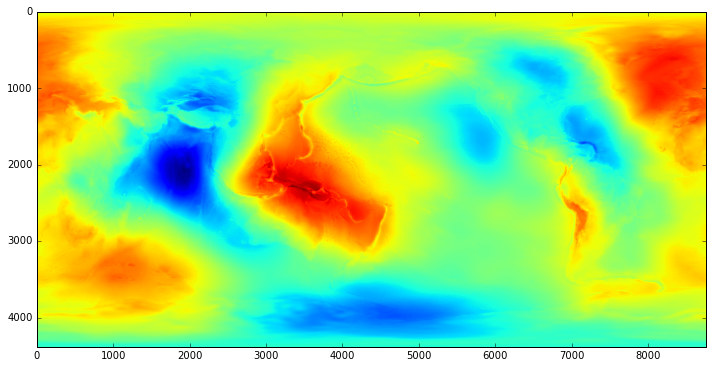

In [5]:
plt.imshow(geoid)

4382 8764


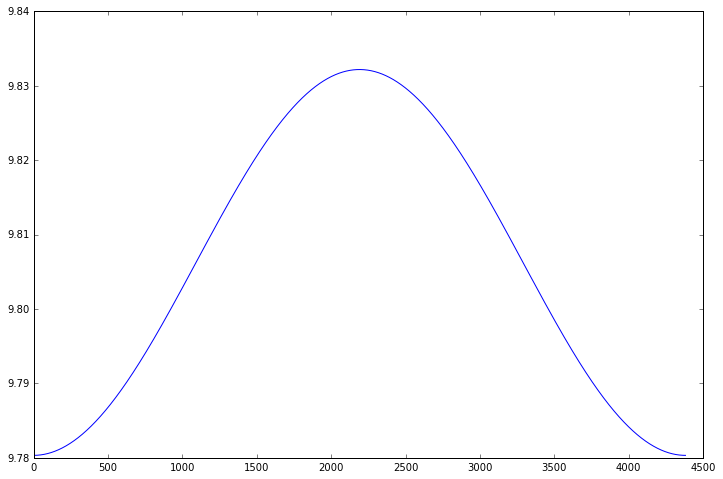

In [6]:
nlat,nlon = geoid.shape
print nlat, nlon
dlat = 180. / nlat
lats = np.linspace(0. + (dlat / 2.), 180. - (dlat / 2.), nlat)
#plt.plot(lats)
normal_gravs = [sht.NormalGravity(lat,GM_earth,omega_earth,a_earth,b_earth) for lat in lats]
ng = np.array(normal_gravs,np.float64)
plt.plot(ng)
#print normal_gravs

-1046.80278545 863.028452941


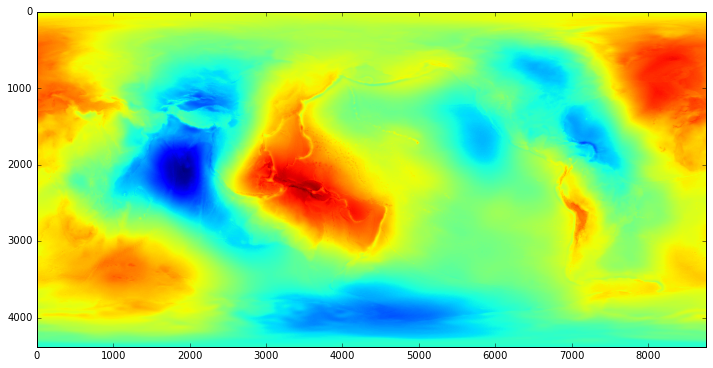

In [7]:
# Brun's formula
T = geoid * ng[:,np.newaxis]
fig = plt.figure()
plt.imshow(T)
#fig.savefig('Timage.png')
print T.min(),T.max()

In [8]:
# In order to exactly match the Driscoll-Healy convolution theorem details, 
# we'll use the ortho-normalized (norm=4) version
# DON'T FORGET TO CALL WITH SAMPLING=2  !!!!!!!!
T_SH = sht.SHExpandDH(T, lmax_calc=max_degree,norm=4,sampling=2)

-1046.80278108 863.029327089


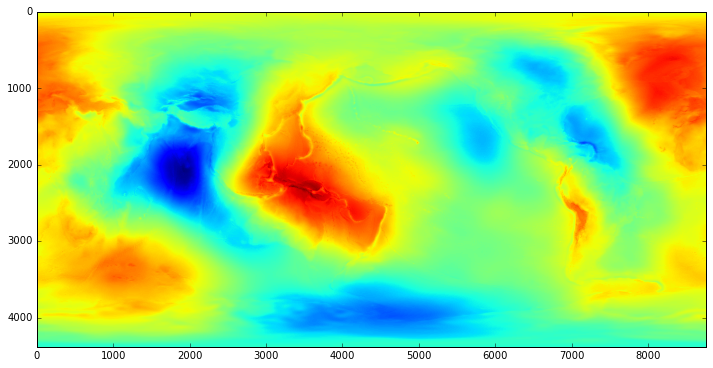

In [9]:
# Sanity check: Do we reproduce T as a grid from the T_SH coefficients?
T_test = sht.MakeGridDH(T_SH,sampling=2,csphase=1,norm=4)
plt.imshow(T_test)
print T_test.min(),T_test.max()

-0.00493284119167 0.00373991565952


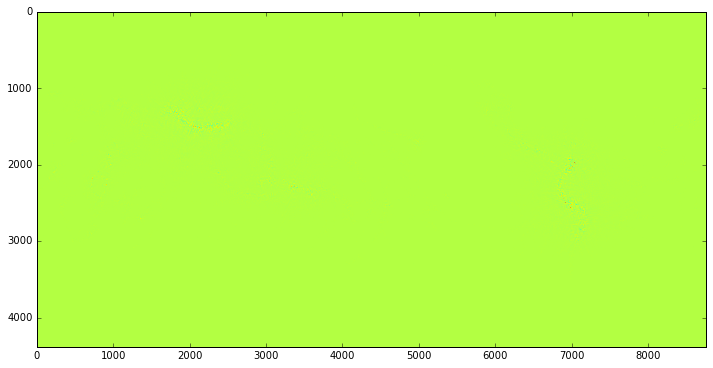

In [10]:
T_err = T-T_test
plt.imshow(T_err)
print T_err.min(),T_err.max()

This next function computes the distance from the North Pole on a sphere of radius $R_e$ to all points on a concentric sphere of radius $r_i$. 

Let $\theta$ = the co-latitude (ranging from 0 at the North Pole to $\pi$ at the South Pole).

Let $R_e$ be the radius of an external sphere with center at the origin. (The subscript e for either Earth or external...)

Let $r_i$ be the radius of an internal sphere concentric with the external one, with the vector ${\bf r}_i$ ending at an arbitrary point on the internal sphere. The length $|{\bf r}_i| = r_i$. We also assume that there is some mass located at ${\bf r}_i$. The distribution of these masses over all orientations of ${\bf r}_i$ and for all internal spheres is the object of our tomography. 

Let the $z$ axis be positive through the North Pole.

Let $r_a$ be the distance along the $z$ axis from the North Pole to the base of the vector perpendicular to the $z$ axis that ends at the position vector ${\bf r}_i$. Also let $r_b$ be the (perpendicular) distance from the $z$ axis to the position vector ${\bf r}_i$.

Finally, let $r_{pm}$ be the distance from the North Pole to a mass located at position vector ${\bf r}_i$.

Then $r_a = R_e - r_i \cos \theta$, $r_b = r_i \sin \theta$, and $r_{pm} = \sqrt{r_a^2 + r_b^2} = \sqrt{(R_e - r_i \cos \theta)^2 + (r_i \sin \theta)^2} = \sqrt{R_e^2 + r_i^2 - 2 r_i R_e \cos \theta}$.

In [20]:
def make_Rpm(R_e,r_i,co_lats,shp):
    rpm_1D = np.sqrt((-2.*r_i*R_e*np.cos(co_lats)) + (R_e**2) + (r_i**2) )
    rpm_2D = np.zeros(shp,np.float64)
    rpm_2D[:,:] = rpm_1D[:,np.newaxis]
    
    return rpm_2D

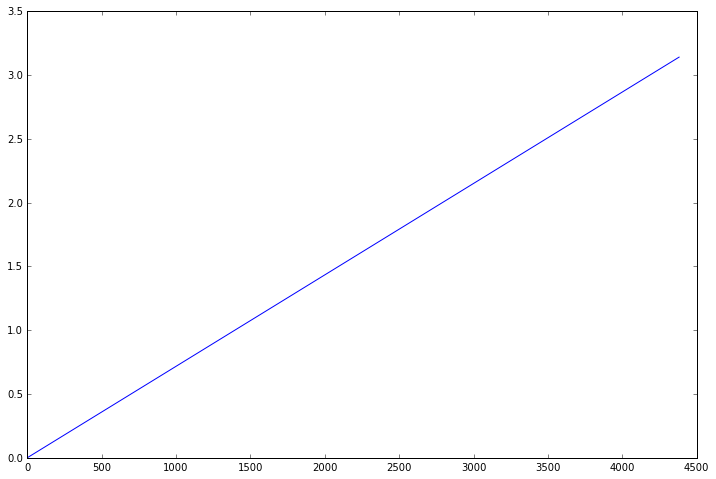

In [21]:
co_lats = np.linspace(0.,np.pi,num=T.shape[0],endpoint=True,dtype=np.double)
plt.plot(co_lats)

In [57]:
r_inner = 6371000. - 600000.
# r_inner = 0.5290 *6371000.
rpm_2D = -make_Rpm(R_e = 6371000., r_i = r_inner, co_lats = co_lats, shp = T.shape)
print 6371000. - r_inner

600000.0


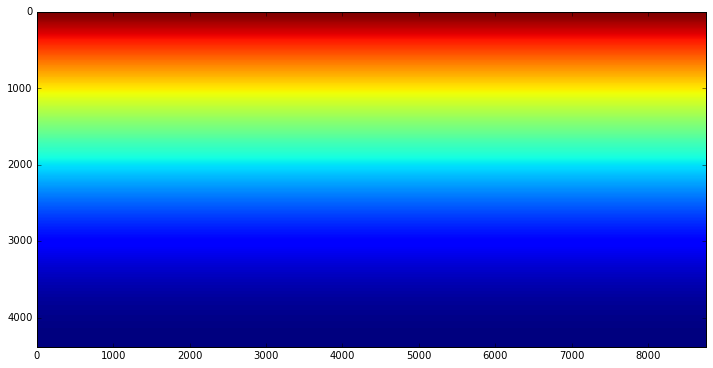

In [33]:
plt.imshow(rpm_2D)

In [24]:
# orthonormalized SH expansion
rpm_2D_SH = sht.SHExpandDH(rpm_2D, norm=4,sampling=2)

In [25]:
print np.max(np.abs(rpm_2D_SH[0,:,0]))
print np.max(np.abs(rpm_2D_SH[1,:,0]))

29882881.8153
0.0


In [26]:
kernel =  rpm_2D_SH[0,:,0]
print kernel.shape

(2191,)


According to Arfken and Weber (4th International edition, 1995; eqn. 12.3) the Legendre polynomial $P_n(\cos \theta)$ coefficient of 1/r is $\left( \frac{a}{r} \right)^n$, where $a$ is the radius of the inner sphere, and $r$ is the radius of the outer sphere. Let's plot those coefficients and see what the look like relative to the stuff we've been evaluating numerically. In our notation, $r$ is $R_e$, while $a$ is $r_i$, so the expression becomes $\left( \frac{r_i}{R_e} \right)^n$.

In [58]:
P_degrees = np.arange(0,max_degree+1,1.)
print len(P_degrees)
P_coeffs = (r_inner/6371000.)**P_degrees
print(len(P_coeffs))

2191
2191


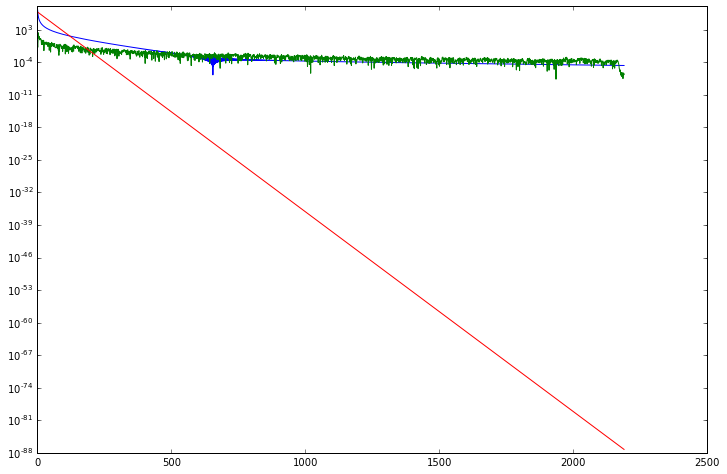

In [59]:
plt.semilogy(np.abs(kernel))
plt.semilogy(np.abs(T_SH[0,:,0]))
plt.semilogy(6371000.*P_coeffs)
#plt.semilogy(np.abs(1./kernel))
#plt.semilogy(np.abs(1./(kernel**2)))


In [60]:
sh_degree = np.arange(T_SH.shape[1])
factor = 2.*np.pi*((1+(2*sh_degree))/(4.*np.pi))**2
#convolved = (factor*kernel)[np.newaxis,:,np.newaxis] * T_SH
convolved = (factor*P_coeffs)[np.newaxis,:,np.newaxis] * T_SH

#convolved = (1./kernel)[np.newaxis,:,np.newaxis] * T_SH


print convolved.shape
#convolved[:,1,1] = 0.

(2, 2191, 2191)


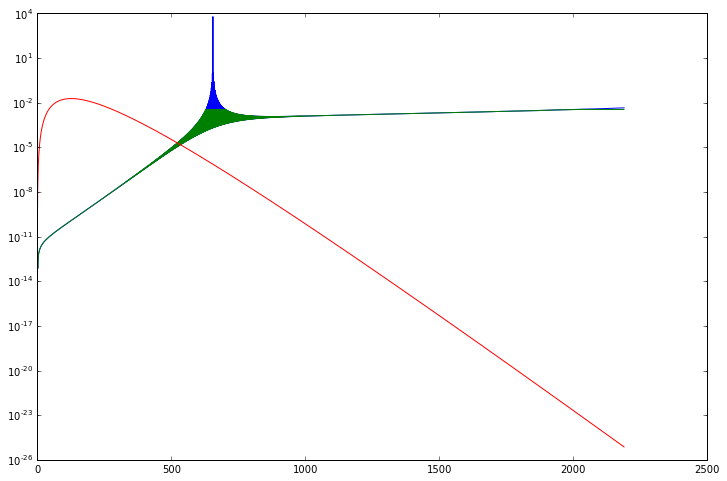

In [31]:
K_filter = 1.0/((kernel * factor)**2)
K_filter_clipped = np.clip(K_filter,0.,3.5e-3)
LK_filter = ((-P_coeffs*factor)**2)/6371000.
plt.semilogy(K_filter)
plt.semilogy(K_filter_clipped)
plt.semilogy(LK_filter)

In [61]:
tomo_r1 = sht.MakeGridDH(convolved,sampling=2,csphase=1,norm=4)

In [ ]:
plt.hist(tomo_r1.flat,bins=100,log=True)

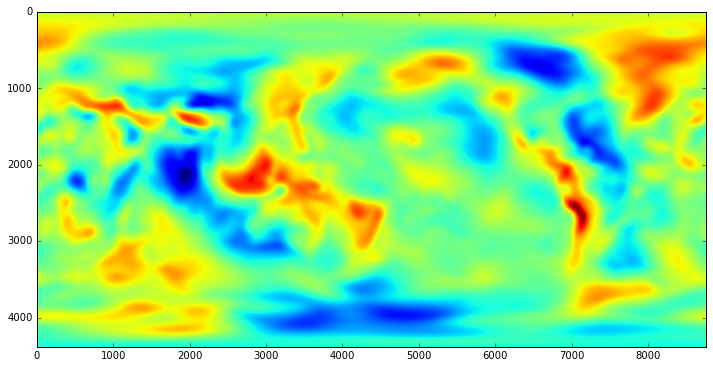

In [62]:
plt.imshow(tomo_r1)

In [37]:
ramp_filter = np.linspace(0.,1.,num=convolved.shape[1],endpoint=True)
ramp_filter_2d = np.sqrt(np.add.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))
beylkin_old_filter_2d = np.add.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter)
# K_filter_2d = K_filter[:,np.newaxis]
cone_filter_2d = np.sqrt(np.outer(ramp_filter*ramp_filter,ramp_filter*ramp_filter))

This next result implements the "Gaussian mollifier" kernel from:

Louis, A. K., Riplinger, M., Spiess, M., & Spodarev, E. (2011). Inversion algorithms for the spherical radon and cosine transform. Inverse Problems, 27 (3), 035015.
URL http://stacks.iop.org/0266-5611/27/i=3/a=035015



0.0100611583483


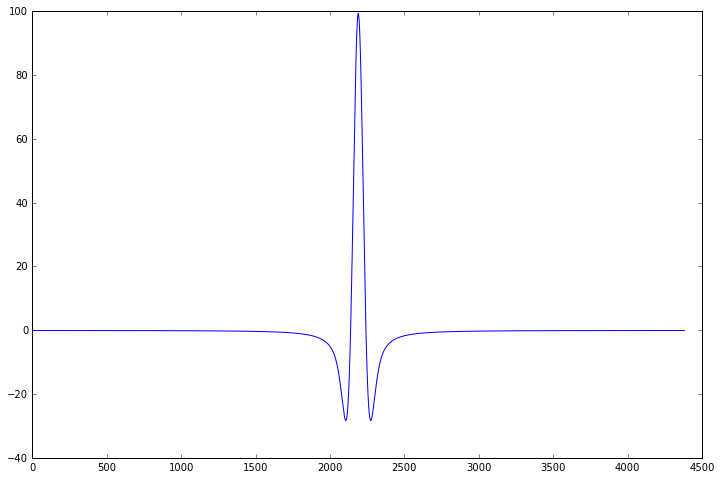

In [77]:
gamma = 0.04
c_gamma = 2.* (np.pi**1.5) *  gamma * np.exp(-(gamma**-2)) * erfi(1./gamma)
print c_gamma
def psi_gamma(theta):
    retval = (1. - (np.sqrt(np.pi)* np.cos(theta)*np.exp(-(np.cos(theta)**2)/gamma**2)*\
                    erfi(np.cos(theta)/gamma) / gamma))/c_gamma
    return retval

foo = psi_gamma(co_lats)

plt.plot(foo)

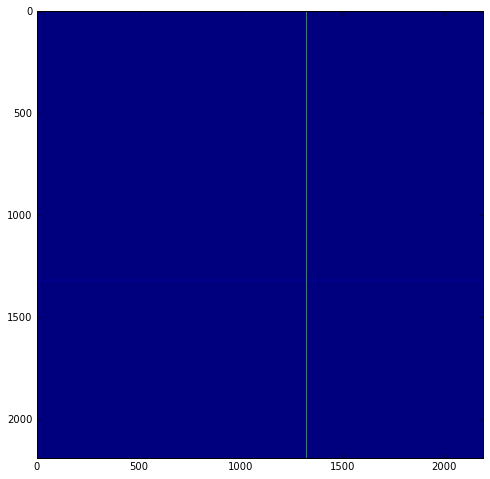

In [38]:
plt.imshow(K_filter_2d)

In [31]:
ramp_filter_2d.shape, convolved.shape

((2191, 2191), (2, 2191, 2191))

In [56]:
filtered_convolved = convolved.copy()
filtered_convolved[0,:,:] *= K_filter_clipped[ :, np.newaxis]
filtered_convolved[1,:,:] *= K_filter_clipped[ :, np.newaxis]

In [26]:
tomo_d50_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [57]:
tomo_d100_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [52]:
tomo_d660_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [116]:
tomo_d2880_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [22]:
tomo_d3000_filtered = sht.MakeGridDH(filtered_convolved,sampling=2,csphase=1,norm=4)

In [ ]:
plt.hist(tomo_d100_filtered.flat,bins=100,log=True)

-1.08866577277 1.02811638317


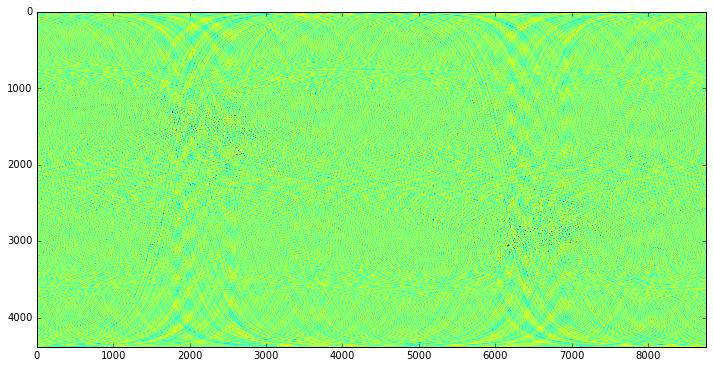

In [28]:
plt.imshow(tomo_d50_filtered)
print tomo_d50_filtered.min(),tomo_d50_filtered.max()

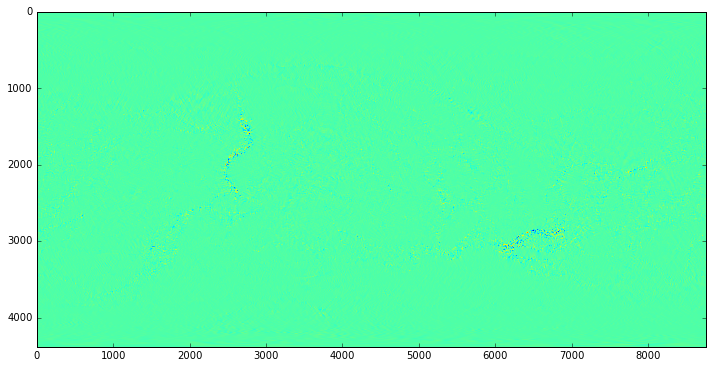

In [58]:
plt.imshow(tomo_d100_filtered)

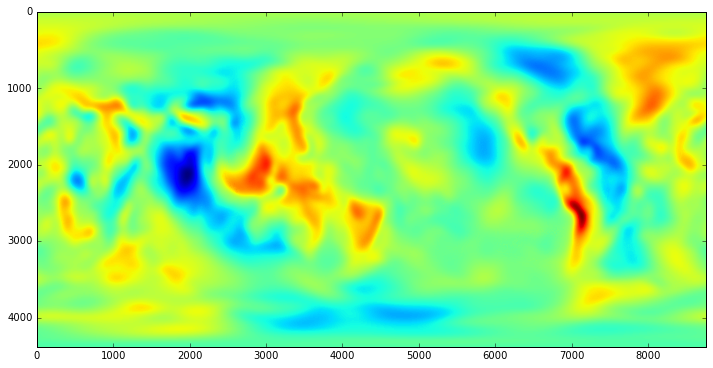

In [53]:
plt.imshow(tomo_d660_filtered)

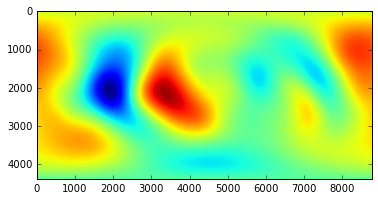

In [117]:
plt.imshow(tomo_d2880_filtered)

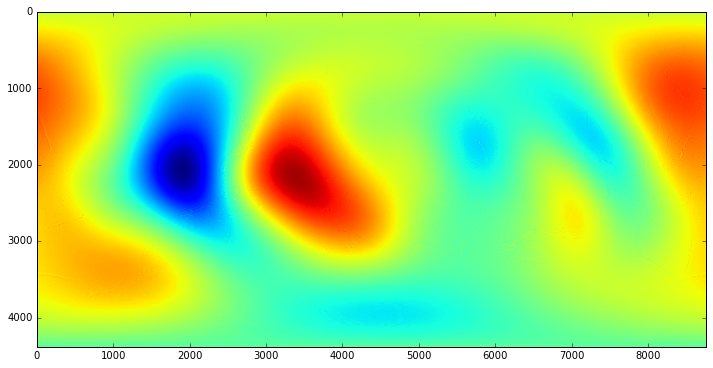

In [27]:
plt.imshow(tomo_d3000_filtered)

In [25]:
plt.rcParams

RcParams({u'agg.path.chunksize': 0,
          u'animation.avconv_args': [],
          u'animation.avconv_path': u'avconv',
          u'animation.bitrate': -1,
          u'animation.codec': u'mpeg4',
          u'animation.convert_args': [],
          u'animation.convert_path': u'convert',
          u'animation.ffmpeg_args': [],
          u'animation.ffmpeg_path': u'ffmpeg',
          u'animation.frame_format': u'png',
          u'animation.html': u'none',
          u'animation.mencoder_args': [],
          u'animation.mencoder_path': u'mencoder',
          u'animation.writer': u'ffmpeg',
          u'axes.axisbelow': False,
          u'axes.edgecolor': u'k',
          u'axes.facecolor': u'w',
          u'axes.formatter.limits': [-7, 7],
          u'axes.formatter.use_locale': False,
          u'axes.formatter.use_mathtext': False,
          u'axes.formatter.useoffset': True,
          u'axes.grid': False,
          u'axes.grid.axis': u'both',
          u'axes.grid.which': u'major',
     

In [1]:
%matplotlib inline
%run GravTomo.py

Loading SHTOOLS documentation




**Old dead code only below here. Mostly preserved for examples of calling routines...**

In [35]:
#d_dr_op = -(2. + np.arange(0,kernel.shape[0]))/(r_inner)
d_dr_op = -(1. + np.arange(1.,kernel.shape[0]+1))/(r_inner)

-0.0429923661583


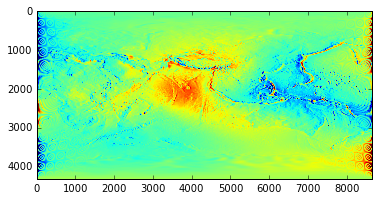

In [36]:
grav_disturbance_SH = d_dr_op * T_SH
grav_disturbance = sht.MakeGridDH(grav_disturbance_SH,sampling=2,csphase=1)
plt.imshow(grav_disturbance,vmin=-0.001,vmax=0.001)
print grav_disturbance.min()

In [23]:
d_dr_convolved = d_dr_op[np.newaxis,:,np.newaxis] * convolved * cone_filter_2d

In [24]:
d_dr_2D = sht.MakeGridDH(d_dr_convolved,sampling=2,csphase=1)

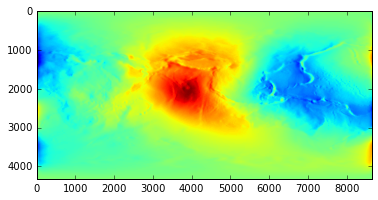

In [25]:
plt.imshow(d_dr_2D)